# PyTorch Tutorial 1: LeNet-5

In [11]:
# import some necessary packages
import os
import torch
import numpy as np
import torch.nn.functional as F

from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.datasets import mnist
from torchvision.transforms import ToTensor

# Model Architecture
![LeNet-5 Model Architecture](https://image.jiqizhixin.com/uploads/editor/5769eae8-69fd-4259-b1d7-3da4499b7037/1525720940926.jpeg)

### Note: the image size of MNIST dataset is 3 $\times$ 28 $\times$ 28, not 3 $\times$ 32 $\times$ 32.

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # INPUT -> C1
        x = F.relu(self.conv1(x))
        # C1 -> S2
        x = self.pool1(x)
        # S2 -> C3
        x = F.relu(self.conv2(x))
        # C3 -> S4
        x = self.pool2(x)

        x = x.view(x.shape[0], -1)
        # S4 -> C5
        x = F.relu(self.fc1(x))
        # C5 -> F6
        x = F.relu(self.fc2(x))
        # F6 -> OUTPUT
        x = self.fc3(x)

        return x

In [13]:
# you can try to adjust the following hyperparameters,
# and find the performance change
lr = 0.5
all_epoch = 20
batch_size = 256

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# if you find the result is 'cpu' but you indeed have a GPU device,
# please check your code, Nvidia driver and conda environment
print(f'Current device: {device}')

# data pipeline
train_dataset = mnist.MNIST(
    root='./train',
    download=True,
    train=True,
    transform=ToTensor()
)
test_dataset = mnist.MNIST(
    root='./test',
    download=True,
    train=False,
    transform=ToTensor()
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
# move the model into GPU (or CPU)
model = Model().to(device)
# optimizer
optimizer = SGD(model.parameters(), lr=lr)
# loss function
loss_fn = CrossEntropyLoss()

Current device: cuda


In [14]:
losses = []

for current_epoch in range(all_epoch):
    # training
    model.train()
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)

        predict_y = model(train_x.float())
        # For CrossEntropyLoss, the target must belong to torch.LongTensor
        # so we need the method `long()`
        loss = loss_fn(predict_y, train_label.long())
        # clear the gradient
        optimizer.zero_grad()
        # back prop
        loss.backward()
        # update model params
        optimizer.step()

        if (idx + 1) % 25 == 0:
            losses.append(loss.item())

    # evaluation
    all_correct_num = 0
    all_sample_num = 0
    # Note:
    # we must start the evaluation mode in the eval phase
    # because gradient computation is not allowed in evaluation
    model.eval()
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)

        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)

        current_correct_num = (predict_y == test_label)
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num

    print(f'Epoch [{current_epoch+1}/{all_epoch}], accuracy: {acc:.3f}')

    if not os.path.isdir('models'):
        os.mkdir('models')
    torch.save(model, f'models/mnist_{acc:.3f}.pt')

print('Training finished!')

Epoch [1/20], accuracy: 0.912
Epoch [2/20], accuracy: 0.967
Epoch [3/20], accuracy: 0.974
Epoch [4/20], accuracy: 0.977
Epoch [5/20], accuracy: 0.978
Epoch [6/20], accuracy: 0.985
Epoch [7/20], accuracy: 0.984
Epoch [8/20], accuracy: 0.983
Epoch [9/20], accuracy: 0.985
Epoch [10/20], accuracy: 0.982
Epoch [11/20], accuracy: 0.981
Epoch [12/20], accuracy: 0.981
Epoch [13/20], accuracy: 0.983
Epoch [14/20], accuracy: 0.936
Epoch [15/20], accuracy: 0.103
Epoch [16/20], accuracy: 0.103
Epoch [17/20], accuracy: 0.103
Epoch [18/20], accuracy: 0.103
Epoch [19/20], accuracy: 0.103
Epoch [20/20], accuracy: 0.103
Training finished!


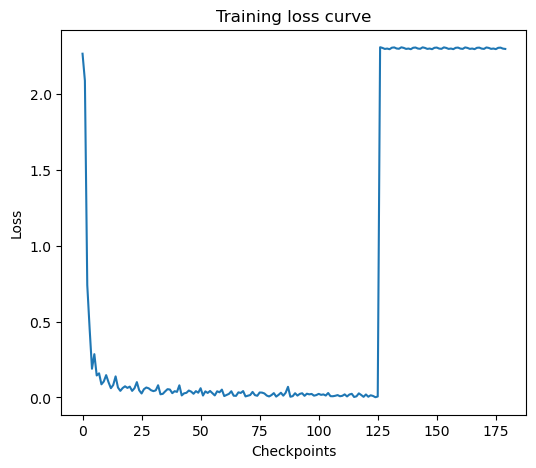

In [15]:
# loss curve visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(losses)
plt.xlabel("Checkpoints")
plt.ylabel("Loss")
plt.title("Training loss curve")
plt.show()